In [1]:
import pickle
from aemulusnu_massfunction.emulator_training import *
from aemulusnu_massfunction.fisher_utils import *

fiducial_h = 0.6736


# #(Plank 2018 table 2. TT,TE,EE+lowE+lensing  + neutrino mass put in by hand)
fiducial_cosmology = {'10^9 As':2.1,
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': 0.02237,
                      'omch2': 0.12,
                      'nu_mass_ev': 0.06,}



#(Same as above but put in DES Y3 OmegaM and Sigma8)
# Ωmh2 =  0.339*fiducial_h**2 # Y3 3x2pt
# Ωνh2 = 0.06/(93.14) #see astro-ph/0603494
# #From the BBN seciton of DES Y3 paper
# Ωbh2 = 2.195/100
# Ωch2 = Ωmh2-Ωbh2-Ωνh2
# fiducial_cosmology = {'10^9 As': 1.520813,  #from σ8 for DES Y3 3x2 and convert_sigma8_to_As.ipynb
#                       'ns': 0.9649,
#                       'H0': 67.36,
#                       'w0': -1,
#                       'ombh2': Ωbh2,
#                       'omch2': Ωch2,
#                       'nu_mass_ev': 0.06,}


oup_cov_fname = 'fiducial_cluster_abundance_covariance_'

for key in fiducial_cosmology:
    ckey = key
    if key == '10^9 As':
        ckey = '1e9As'
    oup_cov_fname += '%s_%f_'%(ckey, fiducial_cosmology[key])

oup_cov_fname = list(oup_cov_fname)

for i,char in enumerate(oup_cov_fname):
    if(char == '.'):
        oup_cov_fname[i] = 'p'

oup_cov_fname = oup_cov_fname[:-1]

oup_cov_fname = ''.join(oup_cov_fname)
oup_cov_fname += '.pkl'

with open(oup_cov_fname, 'rb') as file:
        cluster_count_cov = pickle.load(file)


loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [2]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
from scipy.linalg import cho_factor, cho_solve
cholesky_factor = cho_factor(cov_matrix_2d)
cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                


In [3]:
varied = list(fiducial_cosmology.keys())

In [4]:
labels = {
    '10^9 As': r'$10^9A_s$',
    'ns': r'$n_s$',
    'H0': r'$H_0$',
    'w0': r'$w_0$',
    'ombh2': r'$\Omega_b h^2$',
    'omch2': r'$\Omega_c h^2$',
    'nu_mass_ev': r'$\sum m_\nu$',
    'sigma8' : r'$\sigma_8$'
}

In [5]:
tinker_cov = None
with open('tinker_forecast/tinker_fisher_planck_prior.pkl', 'rb') as file:
    tinker_cov = pickle.load(file)
print(tinker_cov.shape)

(6, 6)


In [6]:
tinker_cov_lowS8 = None
with open('tinker_forecast/tinker_fisher_lowS8_planck_prior.pkl', 'rb') as file:
    tinker_cov_lowS8 = pickle.load(file)
print(tinker_cov_lowS8.shape)

(6, 6)


In [7]:
cov_lowS8 = None
with open('fisher_lowS8_planck_prior.pkl', 'rb') as file:
    cov_lowS8 = pickle.load(file)
print(cov_lowS8.shape)

(6, 6)


In [8]:
cov_highS8 = None
with open('fisher_planck_prior.pkl', 'rb') as file:
    cov_highS8 = pickle.load(file)
print(cov_highS8.shape)

(6, 6)


In [9]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 5
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{xcolor}\newcommand{\semitransp}[2][35]{\color{fg!#1}{#2}}'

In [10]:
param_order = ['10^9 As', 'ns', 'H0','ombh2','omch2','nu_mass_ev']

In [11]:
Ωmh2 =  0.339*fiducial_h**2 # Y3 3x2pt
Ωνh2 = 0.06/(93.14) #see astro-ph/0603494
#From the BBN seciton of DES Y3 paper
Ωbh2 = 2.195/100
Ωch2 = Ωmh2-Ωbh2-Ωνh2
fiducial_cosmology_lowS8 = {'10^9 As': 1.520813,  #from σ8 for DES Y3 3x2 and convert_sigma8_to_As.ipynb
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': Ωbh2,
                      'omch2': Ωch2,
                      'nu_mass_ev': 0.06,}

6


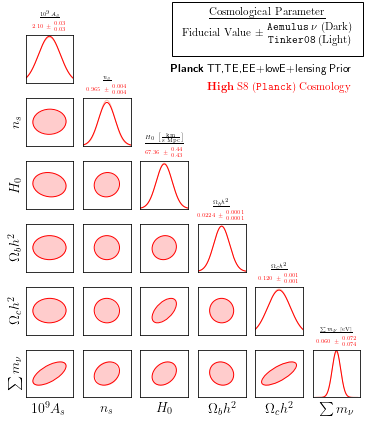

In [12]:
##### lrot=25
#https://arxiv.org/pdf/0906.4123.pdf
def ellipse_params(curr_cov):
    """Implements (2-4) of Coe's paper"""

    a2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          + np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    b2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          - np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    th = [[1/2*np.arctan(2*curr_cov[a][b]/(curr_cov[a][a] - curr_cov[b][b]))*180/np.pi 
           if a != b else -100
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    
    #fixes mixed up width and heights. 
    #a2[i][j] shouldn't equal a2[j][i] (the scales would be all wrong)
    #but should equal b2[j][i] since the width becomes the height
    #and vice versa. 
    for i in range(len(curr_cov)):
        for j in range(len(curr_cov)):
            if(curr_cov[i][i] < curr_cov[j][j]):
                a2[i][j], b2[i][j] = b2[i][j], a2[i][j]
    return(a2, b2, th)

from matplotlib.patches import Ellipse

fig, ax = plt.subplots(6,6, figsize=(6,6), sharex = 'col', sharey='row',)
import matplotlib.cm as cm
vlower, vupper = [None]*6, [None]*6
# for cov_idx, (cov,color) in enumerate(zip([inv_fisher_matrix ], [ 'black'])):
for cov_idx, (cov,color) in enumerate(zip([tinker_cov,
                                           cov_highS8,], ['none', 'red', 'blue'])):

    # Get a color from the colormap based on the index
#     color = 'black'

    a2, b2, th = ellipse_params(cov)
    #     print(nu_mass, cov[1,1])

    fid = [fiducial_cosmology['10^9 As'], 
           fiducial_cosmology['ns'],
           fiducial_cosmology['H0'],
           fiducial_cosmology['ombh2'],
           fiducial_cosmology['omch2'],
           fiducial_cosmology['nu_mass_ev']]
    
    fid = np.zeros_like(fid)
    #Table 1. of Coe
    alpha_1 = 1.52
    alpha_2 = 2.48
    alpha = np.array([alpha_1, alpha_2])
    labels = [r'$10^9A_s$', 
              r'$\Sigma m_\nu$',]
    labels = [r'$10^9A_s$',
              r'$n_s$',
              r'$H_0\ \left[\frac{\rm km} {{\rm s}\ {\rm Mpc}} \right]$',
              r'$\Omega_b h^2$',
              r'$\Omega_c h^2$',
              r'$\sum m_\nu$ [eV]',]
    #make cool elipses
    for i in range(len(cov)):
        for j in range(i):
            wdth = np.sqrt(a2[j][i])*alpha*2
            hght = np.sqrt(b2[j][i])*alpha*2

            facecolor1 ='none'
            facecolor2 ='none'
            
            alphhh = 1.0
            if(color == 'none'):
                alphhh = 0.2
                if(cov_idx == 0):
                    facecolor1= 'red'
                    facecolor2= 'red'
                if(cov_idx == 1):
                    facecolor1= 'blue'
                    facecolor2= 'blue' 

#             sigma_2_ellipse = Ellipse(xy = (fid[j], fid[i]), 
#                                         width= wdth[1],
#                                         height= hght[1],
#                                         angle=th[j][i], ls='--', 
#                                         edgecolor=color, lw=1, alpha=alphhh,
#                                         facecolor=facecolor2)
#             ax[i][j].add_artist(sigma_2_ellipse)  

            sigma_1_ellipse = Ellipse(xy = (fid[j], fid[i]), 
                                        width= wdth[0],
                                        height= hght[0],
                                        angle=th[j][i], ls='-', 
                                        edgecolor=color, 
                                      lw=1, alpha=alphhh,
                                        facecolor=facecolor1)
            ax[i][j].add_artist(sigma_1_ellipse)

            if(cov_idx == 0):
                ax[i][j].set_xlim([fid[j]-1*wdth[0], fid[j]+1*wdth[0]])
                ax[i][j].set_ylim([fid[i]-1*hght[0], fid[i]+1*hght[0]])

            ax[j][i].axis('off')
            space = 2
            if(j==0):
                ax[i][j].set_ylabel(labels[i], fontsize=14)
                if(i == 2):
#                     print('a')
                    ax[i][j].set_ylabel(r'$H_0$', fontsize=14)
                if(i == 5):
#                     print('c')
                    ax[i][j].set_ylabel(r'$\sum m_\nu$', fontsize=14)
                ax[i][i].get_yaxis().set_label_coords(-0.5,0.5)

            if(i==len(cov)-1):
                ax[i][j].set_xlabel(labels[j], fontsize=14)
                if( j == 2):
#                     print('b')
                    ax[i][j].set_xlabel(r'$H_0$', fontsize=14)
                    
#                 ax[i][j].get_xaxis().set_label_coords(0.5,-0.5)
#                 ax[i][j].tick_params(axis='x', labelrotation=lrot)
                ax[i][j].set_xticks([])
    def gauss(mean, sig, x):
        return 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mean)**2/(2*sig**2)) 
    tmp0, tmp1 = ax[0][0].get_ylim()
    ax[0][0].set_ylim(0, tmp1)
    
    
for cov_idx, (cov,color) in enumerate(zip([tinker_cov,
                                           cov_highS8], ['none',  'red', 'blue'])):

    #plot gaussians
    for i in range(len(cov)):

        sig = np.sqrt(cov[i][i])
        x = np.linspace(fid[i]-sig*5, fid[i] + sig*5, 10000)
        # we want to scale so that guassian fit in frame 
        # from what I understand the main thing we want to quantitatively 
        # preserve is the "spread" in x while the 
        # amplitude of the gaussian we can rescale 
        
        
        y = gauss(fid[i], sig,x)
        if(vlower[i] == None):
            vupper[i] = [np.max(y),-1]
            vlower[i] = [0,-1]
            vlower[i][1], vupper[i][1] = ax[i][i].get_ylim()
        lower = vlower[i]
        upper = vupper[i]
        
        scale = (upper[1]-lower[1]) * (np.max(y)/upper[0])
        
        y = lower[1] + .95*scale * y/np.max(y)
        if(color == 'none'):
            if(cov_idx==0):
                color = '#ffbfad'
            elif(cov_idx==1):
                color = '#babaff'
        ax[i][i].plot(x, y, '-', color=color, lw=1)
#         print(color)
    
ax[-1][-1].set_xlabel(r'$\sum m_\nu$', fontsize=14)
# ax[5][5].get_xaxis().set_label_coords(0.5,-0.5)
print(len(cov))
for i in range(len(cov)):
    sig_tinker = np.sqrt(tinker_cov[i][i])
    sig_aemulus = np.sqrt(cov_highS8[i][i])
    sig_tinker_lowS8 = np.sqrt(tinker_cov_lowS8[i][i])
    sig_aemulus_lowS8 = np.sqrt(cov_lowS8[i][i])

#     ax[i][i].plot(x, y, '-', color=color)
    c_txt_l1 = r'\underline{%s}'%labels[i] + '\n'
    
    if(i==3):
        #omb h2
        c_txt_l2 = r'{%.4f $\pm\ \begin{matrix} %.4f \\ %.4f \end{matrix}$}'%(fiducial_cosmology[param_order[i]], sig_aemulus, sig_tinker)
        c_txt_l3 = r'{%.4f $\pm\ \begin{matrix} %.4f \\ %.4f \end{matrix}$}'%(fiducial_cosmology_lowS8[param_order[i]], sig_aemulus_lowS8, sig_tinker_lowS8)

    elif(i in [0,2]):
        c_txt_l2 = r'{%.2f $\pm\ \begin{matrix} %.2f \\ %.2f \end{matrix}$}'%(fiducial_cosmology[param_order[i]], sig_aemulus, sig_tinker)
        c_txt_l3 = r'{%.2f $\pm\ \begin{matrix} %.2f \\ %.2f \end{matrix}$}'%(fiducial_cosmology_lowS8[param_order[i]], sig_aemulus_lowS8, sig_tinker_lowS8)

    else:
        c_txt_l2 = r'{%.3f $\pm\ \begin{matrix} %.3f \\ %.3f \end{matrix}$}'%(fiducial_cosmology[param_order[i]], sig_aemulus, sig_tinker)
        c_txt_l3 = r'{%.3f $\pm\ \begin{matrix} %.3f \\ %.3f \end{matrix}$}'%(fiducial_cosmology_lowS8[param_order[i]], sig_aemulus_lowS8, sig_tinker_lowS8)
#     ax[i][i].text(0.5, 1.1,
#             s=c_txt_l3,
#             transform=ax[i][i].transAxes,
#             horizontalalignment='center',
#             verticalalignment='bottom',
#                  color='blue')
    ax[i][i].text(0.5, 1.1,
            s=c_txt_l2,
            transform=ax[i][i].transAxes,
            horizontalalignment='center',
            verticalalignment='bottom',
                 color='red')
    ax[i][i].text(0.5, 1.25,
            s=c_txt_l1,
            transform=ax[i][i].transAxes,
            horizontalalignment='center',
            verticalalignment='bottom')



    ax[i][i].set_yticks([])
# ax[-1][-1].tick_params(axis='x', labelrotation=lrot)
ax[-1][-1].set_xticks([])

    
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[i][j].set_box_aspect(1)

meta_txt = r'\underline{Cosmological Parameter}' + '\n'+ r'Fiducial Value $\pm\ \begin{matrix}  \textrm{\texttt{Aemulus} $\nu$ (Dark)} \\ \textrm{\texttt{Tinker08} (Light)}  \end{matrix}$'  
high_txt = r'\textbf{High} S8 (\texttt{Planck}) Cosmology'
low_txt = r'\textbf{Low} S8 (\texttt{DES Y3}) Cosmology'


offset_txt = 0.125-0.02
offset_txt_x = 0.025-0.02
fig.text(0.68+offset_txt_x, .81+offset_txt,
            s=meta_txt,
            horizontalalignment='center',
            verticalalignment='center',
         fontsize=11,
        bbox=dict(facecolor='none', edgecolor='k', pad=10.0))

fig.text(0.875+offset_txt_x, .67+offset_txt,
            s=high_txt,
            horizontalalignment='right',
            verticalalignment='center',
         fontsize=11,
         color='red',)

# fig.text(0.875+offset_txt_x, .63+offset_txt,
#             s=low_txt,
#             horizontalalignment='right',
#             verticalalignment='center',
#          fontsize=11,
#          color='blue',)

fig.text(0.875+offset_txt_x, .71+offset_txt,
            s=r'{\textsf{\textbf{Planck} TT,TE,EE+lowE+lensing Prior}}',
            horizontalalignment='right',
            verticalalignment='center',
         fontsize=11,
         color='k',)

# leg = plt.legend(title=meta_txt, loc='upper left')
# leg.get_frame().set_edgecolor('k')
# leg.get_frame().set_facecolor('none')
# leg._legend_box.align = "right"
# plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.9)


plt.savefig('Planck 2018+HMF.pdf')#, bbox_inches='tight')#, pad_inches=0.1)